# 3. Übung Geodatenanalyse
## Analyse von Bewegungsdaten II

In der heutigen Übung werden Sie aus GPS-Trackingdaten trajektorien extrahieren und diese anschliessend analysieren. Die Übung knüpft dabei direkt an die Übung 2 an und besteht aus folgenden teilen: 

- __Teil 1:__ Validierung der Ergebnisse aus Übung 2 (Extrahierung von Aufenthaltspunkten).
- __Teil 2:__ Implementierung eines Algorithmus zur Segmentierung von trajektorien basierend auf bereits extrahierten Aufenthaltspunkten. 
- __Teil 3:__ Analyse der Trajektorien über Histogramme und durch die mittles Merkmalberechnung und über Clustering mit ähnlichkeitsmaasen (Fréchet Distanz)



In [1]:
import datetime
import pyproj

import numpy as np
import ipyleaflet as ipy 
import geopandas as gpd
import json
import pandas as pd
import os
from gda_sdm2_functions import read_romataxidata, apply_dbscan, transform, filter_by_label, \
                                get_tripleg_geometry_from_points, get_tripleg, get_ipyleaflet_trackpoint_layer

from ipywidgets import HTML
from shapely.geometry import LineString
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
import matplotlib
import time
from ipyleaflet import WidgetControl
from utils import calculate_distance_matrix

crs_wgs84= "EPSG:4326"

We define some elements for plotting

In [2]:
tripleg_style={'opacity': 0.8, 'width': 8, 'color': 'Blue'}
tripleg_hoverstyle={'color': '#b08a3e' , 'fillOpacity': 0.8}


html = HTML("")
html.layout.margin = '0px 20px 20px 20px'
tripleg_info_box = WidgetControl(widget=html, position='topright')

def tripleg_hover_info(feature, **kwargs):
    string_list = []
    string_list.append("<table>")
    for var_name in feature['properties']:
        value = feature['properties'][var_name]
        string_list.append("<tr> <td>{}:</td>  <td>&emsp;</td> <td>{}</td> </tr>\n".format(var_name, value))
   
    string_list.append("</table>")
    html.value = "".join(string_list)
    

## Validierung der Ergebnisse aus Übung 2

### 1.1 Berechnen der Ergebnisse der letzten Übung
Zuerst berechnen wir die Ergebnisse aus Übung 2 erneut. Dafür haben wir die Funktionen die Sie in Übung 2 bearbeitet haben in der Datei ``gda_sdm2_functions.py`` zusammengefasst. 


In [3]:
# Path to input file
input_file = os.path.join('input_data', 'taxi_21.txt')

# Read data
data_orginal = read_romataxidata(input_file, nrows=5000)

# Apply transformations
data = transform(data_orginal, timescale=60)

# Calculate clusters with dbscan
labels, core_samples_indices = apply_dbscan(data, eps=5, min_samples=10, metric='chebyshev')

Estimated number of clusters: 47


### 1.2 Visualisierung der Staypoints
Um uns die Daten der letzten Woche nochmals genauer anzusehen, möchten wie sie Visualsieren. Dazu fassen wir die Daten in einem [Geopandas Dataframe](https://github.com/geopandas/geopandas) zusammen. Ein Geodataframe ist eine python Datenstruktur die es uns ermöglicht effizient mit Geodaten umzugehen und sie später zu visualisieren. Alle Daten die wir visualsieren möchten, müssen also in dem Geodataframe stehen. Um die Ergebnisse gut analysieren zu können und um später mit den Daten weiterarbeiten zu könenn, brauchen wir vor allem die folgenden Informationen:
- __Geometrie__
- __Zeitstempel__
- __Clusterlabel__ 
- __Kernpunktindikator__

Dafür verbinden wir die Originaldaten (nicht die transformierten Daten, diese haben keine Zeitstempel mehr) mit den Ergebnissen des Cluteringalgorithmus.


In [4]:
# Construct Geodataframe from original data
italy_gdf = gpd.GeoDataFrame(data=data_orginal, columns= ['long', 'lat',  'timestamp'], 
            geometry=gpd.points_from_xy([row[0] for row in data_orginal], [row[1] for row in data_orginal]), crs=crs_wgs84)

# Add clustering information
italy_gdf['is_core'] = False
italy_gdf.loc[core_samples_indices, 'is_core'] = True
italy_gdf['label'] = labels.astype('int')

# make sure the dataframe is sorted by tracking time and show first lines
italy_gdf.sort_values(by='timestamp', inplace=True)
italy_gdf.head()

,long,lat,timestamp,geometry,is_core,label
0,12.524926,41.936760,2014-02-02 14:32:17.886734,POINT (12.52493 41.93676),False,-1
1,12.524926,41.936760,2014-02-02 14:32:17.887344,POINT (12.52493 41.93676),False,-1
2,12.523382,41.935415,2014-02-02 14:32:25.942641,POINT (12.52338 41.93541),False,-1
3,12.521539,41.933817,2014-02-02 14:32:40.983523,POINT (12.52154 41.93382),False,-1
4,12.521023,41.933368,2014-02-02 14:32:56.936338,POINT (12.52102 41.93337),False,-1


In [5]:
print(italy_gdf['label'].unique())

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


Die Daten im Geopandasformat geben uns schon jetzt die Möglichkeit sie einfach und schnell über die ``gdf.plot()`` zu visualisieren. Um die Ergbnisse gut zu verstehen, ist es aber hilfreich, die Ergebnisse interaktiv auf einer Karte darzustellen.

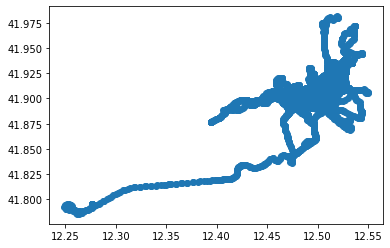

In [6]:
italy_gdf.plot()

In [7]:
m = ipy.Map(center=(41.888, 12.5215), zoom = 12) # basemap= ipy.basemaps.Esri.WorldTopoMap)
m.add_control(ipy.LayersControl())

In [8]:
layer_noise, layer_sp = get_ipyleaflet_trackpoint_layer(italy_gdf.copy(), min_label=6, max_label=8, slack=10)
m.add_layer(layer_noise)
m.add_layer(layer_sp)

(830, 6)


Sehen Sie sich die Interaktive Karte an, sehen die Ergebnisse sinvoll aus? Die einzelnen Trackpunkte sind in Grau eingezeichnet, Staypoints (Punkte die zu einem Cluster gehören) sind etwas grösser in Farbe eingezeichnet.

In [9]:
m

Map(center=[41.888, 12.5215], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [10]:
italy_gdf.columns

Index(['long', 'lat', 'timestamp', 'geometry', 'is_core', 'label'], dtype='object')

## Teil 2: Segmentierung von Triplegs





x	y	timestamp_norm	label	geometry	timestamp	is_core
0	294810.534620	4.645718e+06	46952.298112	-1.0	POINT (12.52493 41.93676)	2014-02-02 14:32:17.886734

In [11]:
pd.set_option('display.max_rows', 1000)
trackpoint_list = italy_gdf[['timestamp', 'label', 'geometry']].values.tolist()
italy_gdf.loc[380:420,['timestamp', 'label', 'geometry']]

,timestamp,label,geometry
380,2014-02-02 16:02:58.614868,-1,POINT (12.46918 41.90565)
381,2014-02-02 16:03:13.260344,-1,POINT (12.46901 41.90554)
382,2014-02-02 16:03:28.936004,-1,POINT (12.46901 41.90554)
383,2014-02-02 16:03:43.393432,0,POINT (12.46891 41.90550)
384,2014-02-02 16:03:58.530495,0,POINT (12.46891 41.90550)
385,2014-02-02 16:04:13.319161,0,POINT (12.46891 41.90550)
386,2014-02-02 16:04:27.911029,0,POINT (12.46891 41.90550)
387,2014-02-02 16:04:45.169180,0,POINT (12.46891 41.90550)
388,2014-02-02 16:04:58.274886,0,POINT (12.46891 41.90550)
389,2014-02-02 16:05:12.881226,0,POINT (12.46891 41.90550)


### Teil 2.1 Implementierung des Algorithmus

In [12]:
# initialize
n = len(trackpoint_list)
tripleg_list = []
i = 0

# iterate all trackpoints
while (i < (n-1)):

    # check if new tripleg begins
    if trackpoint_list[i][1] == -1:
        
        
        # store information from tripleg start
        tripleg_previouslabel = trackpoint_list[i-1][1]
        tripleg_starttime = trackpoint_list[i][0]
        tripleg_point_list = []
        
        # iterate from start of tripleg until end of tripleg
        j = i
        while j < (n -1) and trackpoint_list[j][1] == -1: 
        
            # store trackpoints of tripleg
            tripleg_point_list.append(trackpoint_list[j][2])
            j +=1
                    
        # end of tripleg
        
        # if we have at least 2 points in the tripleg_point_list, we store the tripleg 
        if len(tripleg_point_list) > 2:
        
            # collect tripleg information rember, j is now pointing on a staypoint and therefore on a non-tripleg point 
            tripleg_geometry = get_tripleg_geometry_from_points(tripleg_point_list)
            tripleg_nextlabel = trackpoint_list[j][1]
            tripleg_endtime = trackpoint_list[j-1][0]

            # append tripleg information (as tuple or list) to the 'tripleg_list'.
            # The order has to be (tripleg_previous_label, tripleg_nextlabel, tripleg_starttime, tripleg_endtime, tripleg_geometry)
            tripleg_list.append((tripleg_previouslabel, tripleg_nextlabel, tripleg_starttime, tripleg_endtime, tripleg_geometry))
        
        # set i counter to the next point non-tripleg point
        i = j
        

                
    else:
        i +=1           

### 2.2 Visualisierung der Ergebnisse:
Um die Ergebnisse zu visualisieren, brauchen wir zunächst wieder geodataframes

In [13]:
# transform data into a geodataframe. 'tripleg_list' has to be a list of tuples e.g.,
#(cluster_start, cluster_end, start_time, end_time, geometry) or a list of lists with the same order of items
tripleg_gdf = pd.DataFrame(tripleg_list, columns=['prevlabel', 'nextlabel', 'start_time', 'end_time', 'geometry'])
tripleg_gdf = gpd.GeoDataFrame(tripleg_gdf, geometry=tripleg_gdf.geometry, crs=crs_wgs84)

# transform timestamps to strings for plotting
tripleg_gdf['start_time'] = tripleg_gdf['start_time'].dt.strftime("%Y-%m-%d %H:%M:%S")
tripleg_gdf['end_time'] = tripleg_gdf['end_time'].dt.strftime("%Y-%m-%d %H:%M:%S")

Initialize map

In [14]:
m = ipy.Map(center=(41.8881987655463, 12.5215863435528), zoom = 12) # basemap= ipy.basemaps.Esri.WorldTopoMap)
min_label = 6
max_label = 8
m.add_control(ipy.LayersControl())
m.add_control(tripleg_info_box)
m.add_layer(layer_noise)
m.add_layer(layer_sp)
m

Map(center=[41.8881987655463, 12.5215863435528], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

In [15]:
# add one tripleg
#geo_data = ipy.GeoData(geo_dataframe=tripleg_gdf[tripleg_gdf['prevlabel']==19], name='triplegs', style=tripleg_style, hover_style=tripleg_hoverstyle)

# add a range of triplegs (recommended)
tripleg_gdf_filtered = filter_by_label(tripleg_gdf, min_label, max_label, label_col_name='prevlabel')
geo_data = ipy.GeoData(geo_dataframe=tripleg_gdf_filtered, name='triplegs', style=tripleg_style, hover_style=tripleg_hoverstyle)

# add all triplegs
#geo_data = ipy.GeoData(geo_dataframe=tripleg_gdf, name='triplegs', style=tripleg_style, hover_style=tripleg_hoverstyle)

geo_data.on_hover(tripleg_hover_info)
m.add_layer(geo_data)


In [16]:



tripleg_gdf



,prevlabel,nextlabel,start_time,end_time,geometry
0,-1,0,2014-02-02 14:32:17,2014-02-02 16:03:28,"LINESTRING (12.52493 41.93676, 12.52493 41.936..."
1,0,1,2014-02-02 16:09:29,2014-02-02 16:47:56,"LINESTRING (12.46855 41.90538, 12.46564 41.907..."
2,2,3,2014-02-02 17:00:09,2014-02-02 17:30:05,"LINESTRING (12.50092 41.90116, 12.50075 41.901..."
3,3,4,2014-02-02 17:32:50,2014-02-02 17:35:05,"LINESTRING (12.50196 41.90265, 12.50202 41.902..."
4,4,5,2014-02-02 17:39:06,2014-02-02 17:40:52,"LINESTRING (12.50249 41.90209, 12.50251 41.902..."
5,6,7,2014-02-02 17:54:38,2014-02-02 18:16:42,"LINESTRING (12.50284 41.90198, 12.50280 41.901..."
6,7,8,2014-02-02 18:21:00,2014-02-02 19:34:51,"LINESTRING (12.49201 41.91792, 12.49263 41.917..."
7,8,8,2014-02-02 19:36:21,2014-02-02 19:38:06,"LINESTRING (12.53010 41.90983, 12.53010 41.909..."
8,8,9,2014-02-02 19:40:06,2014-02-02 21:07:28,"LINESTRING (12.52989 41.90977, 12.52989 41.909..."
9,9,10,2014-02-02 21:12:43,2014-02-02 21:13:58,"LINESTRING (12.47289 41.89700, 12.47288 41.897..."


## Teil 3: Analyse der Triplegs (Bonus)

### 3.1 Analyse der eigenschaften (Geschwindigkeit, Länge, Dauer)

In [17]:
tripleg_gdf_2d = tripleg_gdf.to_crs("EPSG:25833")

In [18]:

tripleg_gdf_2d['length'] = tripleg_gdf_2d.apply(lambda x: x.geometry.length, axis=1)
tripleg_gdf_2d['start_time'] = pd.to_datetime(tripleg_gdf_2d['start_time'], utc=True, format="%Y-%m-%d %H:%M:%S")
tripleg_gdf_2d['end_time'] = pd.to_datetime(tripleg_gdf_2d['end_time'], utc=True, format="%Y-%m-%d %H:%M:%S")
tripleg_gdf_2d['duration'] = tripleg_gdf_2d['end_time'] - tripleg_gdf_2d['start_time']
tripleg_gdf_2d['speed'] = (tripleg_gdf_2d['length']/1000)/ (tripleg_gdf_2d['duration'].dt.seconds/3600)
tripleg_gdf_2d.replace([np.inf, -np.inf], np.nan, inplace=True)

Text(0.5, 1.0, 'speed')

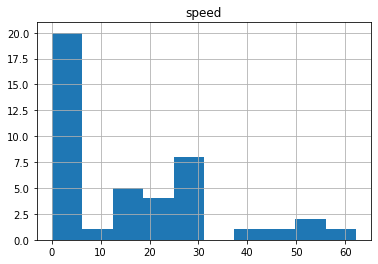

In [19]:
tripleg_gdf_2d['speed'].dropna().hist()
plt.title('speed')

Text(0.5, 1.0, 'length in km')

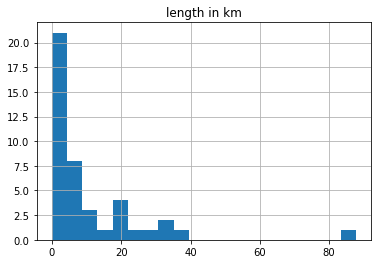

In [20]:
(tripleg_gdf_2d['length']/1000).hist(bins=20)
plt.title('length in km')

Text(0.5, 1.0, 'duration in minutes')

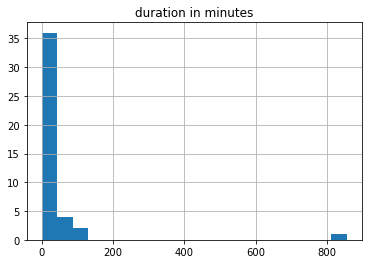

In [21]:
(tripleg_gdf_2d['duration'].dt.seconds/60).hist(bins=20)
plt.title('duration in minutes')

Investigate the outlier...

###  3.2 Clustering über Distanzmetrik (frechet)

In [22]:
# tripleg_gdf_2d_red = tripleg_gdf_2d.copy() # volle Matrix (dauert etwas...)
tripleg_gdf_2d_red = tripleg_gdf_2d.iloc[0:15,:].copy()
D_frechet = calculate_distance_matrix(tripleg_gdf_2d_red, distance='frechet')

11855.957392200567

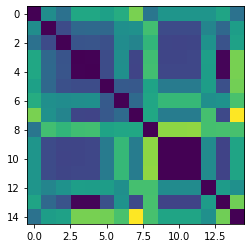

In [23]:
plt.imshow(D_frechet)
np.max(D_frechet)

In [24]:
km = KMeans(n_clusters=4).fit(D_frechet)
km.labels_

array([0, 3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 3, 0, 1, 0])

In [25]:
tripleg_gdf_2d_red['tripleg_cluster'] = km.labels_ +1

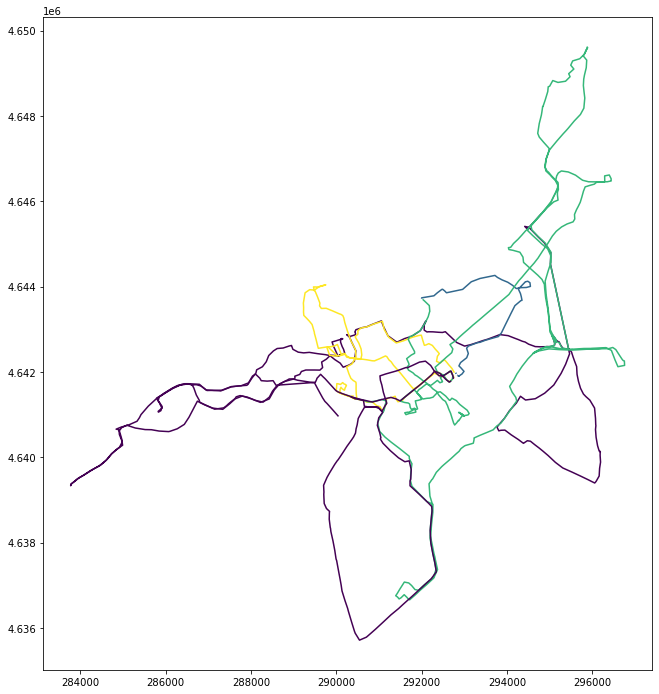

In [26]:
tripleg_gdf_2d_red.plot(column='tripleg_cluster', figsize=(12,12))